In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from datetime import timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', 50) 

import os
os.listdir('data/Loans Stats/')

['archive_2021_06',
 'archive_2021_12',
 'archive_2022_03',
 'Banking Stats.XLS',
 'Banking stats_2.XLS']

### Parameters

In [3]:
image_folder = 'output'

file_1 = 'data/Loans Stats/Banking Stats.XLS'
file_2 = 'data/Loans Stats/Banking stats_2.XLS'

start_date = "2010-01-01"

opr_df         = read_csv('data/opr/opr_rate.csv')
end_date = opr_df["DATE"].max() - pd.offsets.BMonthEnd(1)
# end_date = "2022-02-28"  # to update
print("End Date:", end_date)

NameError: name 'read_csv' is not defined

### Read Data

In [152]:
loan_3_df        = pd.read_excel(file_1, sheet_name='Loan_3')
int_df           = pd.read_excel(file_1, sheet_name='Int')
npl_df           = pd.read_excel(file_1, sheet_name='NPL')[['Unnamed: 0','Unnamed: 17']]
application_df = pd.read_excel(file_2, sheet_name='Applications by purpose', header=None)
approval_df    = pd.read_excel(file_2, sheet_name='Approvals by purpose', header=None)

def get_year_month(df):  
    df['year_month'] = df['DATE'].map(lambda x: datetime(x.year, x.month, 1).date())
    return df

def filter_date(df,start_date, end_date, date_col='year_month'):
    return df.query('{dtcol} >= "{}" and {dtcol} <= "{}"'.format(start_date, end_date, dtcol=date_col))

def read_csv(file):
    '''
    with parse_date
    '''
    return pd.read_csv(file, parse_dates=['DATE'])

opr_df         = read_csv('data/opr/opr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
m3_price       = read_csv('data/opr/m3_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE") 
srr            = read_csv('data/opr/srr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
bond_yields    = read_csv('data/opr/magy10yr.csv').pipe(filter_date, start_date, end_date, "DATE")

In [153]:
npl_df

,Unnamed: 0,Unnamed: 17
0,3 Months,Gross NPL
1,Annual,NaN
2,1988,NaN
3,1989,NaN
4,1990,NaN
...,...,...
322,2022-01-01 00:00:00,1.502733
323,2022-02-01 00:00:00,1.525216
324,NaN,NaN
325,NaN,NaN


### Data Processing

In [124]:
def trim_df(df):
    dff = df[list(range(15))].copy()
    dff.columns  = dff.iloc[3][:2].append(dff.iloc[2][2:]).tolist()
    dff = dff.iloc[4:].copy().dropna(subset=['Month'])
    dff['Year'] = dff['Year'].ffill()
    dff['year_month'] = dff.apply(lambda x: '{}-{}-01'.format(x['Year'], str(x['Month']).zfill(2)),1)
    return dff

def process_npl(npl):
    npl.columns= ['Date', 'Gross NPL']
    npl = npl.iloc[npl[npl['Date']=='Monthly'].index[0]+1:].dropna().copy()
    npl['Date'] = pd.to_datetime(npl['Date'])
    return npl

def process_opr(opr_df):
    def label(x):
        if x > 0:
            return 'hike'
        elif x< 0 :
            return 'cut'
        else:
            return 'stay'
    
    opr_df['label'] = opr_df['px_last'].diff().map(label) 
    opr_month = pd.pivot_table(opr_df, index='year_month', columns='label', values='px_last').fillna(0)\
                  .applymap(lambda x: 1 if x!= 0 else 0).reset_index()
    opr_month['label'] = opr_month.apply(lambda x: 'cut' if x['cut']==1 else ('hike' if x['hike'] == 1 else 'stay'), 1)
    return opr_df, opr_month

application_df_1 = trim_df(application_df).pipe(filter_date, start_date, end_date)
approval_df_1 = trim_df(approval_df).pipe(filter_date, start_date, end_date).\
                                    rename(columns={'Residential':'Residential mortgages',
                                                    'Non-residential':'Non-residential mortgages',
                                                     'Consumer goods':'Consumer durable goods', 
                                                    'Other ':'Other purpose'})
npl = process_npl(npl_df).pipe(filter_date, start_date, end_date, "Date")
opr_df, opr_month = process_opr(opr_df)

### Visualization

In [125]:
def plot_multi_lines(df, x_axis, y_axes):
    fig = go.Figure()
    for col in y_axes:
        fig.add_trace(go.Scatter(x=df[x_axis], y=df[col]/1000, name=col))
    fig.update_xaxes(dtick='M12')
    return fig

def add_title(fig, title, ylabel="Purposes (billion) [MYR]"):
    fig.update_layout(template='ygridoff',
                      title=title,
                    yaxis=dict(
                    title=ylabel,
                    titlefont=dict(
                        color="#7f7f7f"
                    ),
                    tickfont=dict(
                        color="#7f7f7f"
                    )
                ),
                )
    return fig



def plot_multi_lines(df, x_axis, y_axes):
    fig = go.Figure()
    for col in y_axes:
        fig.add_trace(go.Scatter(x=df[x_axis], y=df[col]/1000, name=col))
    fig.update_xaxes(dtick='M12')
    return fig



In [126]:
# application_df_1["Date"] = pd.to_datetime(application_df_1["year_month"])
# application_df_1a = application_df_1[purposes].set_index("Date")
# application_df_1a

In [127]:
application_df_1["Date"] = pd.to_datetime(application_df_1["year_month"])
purposes = [i for i in application_df_1 if i not in ['Date', 'Year','Month','TOTAL','year_month','Auto','Consumer durable goods']]
purposes
application_df_1a = application_df_1.set_index("Date")[purposes]
application_df_2 = application_df_1a.rolling(12).mean()
approval_df_1["Date"] = pd.to_datetime(approval_df_1["year_month"])
approval_df_1a = approval_df_1.set_index("Date")[purposes]
approval_df_2 = approval_df_1a.rolling(12).mean()


In [194]:
def preproc_app_df(df):
    app_df_1 = df.pct_change(12).loc[df.index[-4]:]
    col_1 = app_df_1.T.columns[-1]
    new_col = [j.strftime("%b%y-YoY") for j in app_df_1.T.columns]
    table_application_1 = (  app_df_1.T.sort_values(col_1, ascending=False)*100).round(2)
    table_application_1.columns = new_col
    return table_application_1

preproc_app_df(application_df_1a)

,Nov21-YoY,Dec21-YoY,Jan22-YoY,Feb22-YoY
Passenger cars,32.77,32.90,47.56,45.13
Credit cards,8.60,17.46,29.70,38.93
Working capital,22.35,56.74,8.08,29.35
Purchase of securities,-18.10,-6.46,36.87,17.63
Non-residential mortgages,33.56,29.82,1.30,11.18
Residential mortgages,36.09,33.79,6.45,8.54
Personal uses,-6.31,-9.64,-13.17,-15.25
Purchase of fixed assets,16.81,577.04,66.79,-16.07
Other purpose,104.54,-73.70,-37.41,-16.39
Construction,-50.83,-47.45,2.77,-18.17


In [195]:
preproc_app_df(approval_df_1a)

,Nov21-YoY,Dec21-YoY,Jan22-YoY,Feb22-YoY
Credit cards,23.66,36.57,63.53,62.93
Non-residential mortgages,39.05,31.62,51.69,49.34
Purchase of securities,16.91,-8.67,72.28,47.07
Construction,-21.25,-48.35,-38.93,43.33
Working capital,8.25,66.41,30.49,36.11
Passenger cars,7.53,14.59,33.94,31.21
Residential mortgages,16.66,37.85,25.27,-1.82
Personal uses,1.10,-0.43,3.13,-11.23
Purchase of fixed assets,87.79,250.57,-38.01,-18.39
Other purpose,74.05,-61.70,-7.24,-60.24


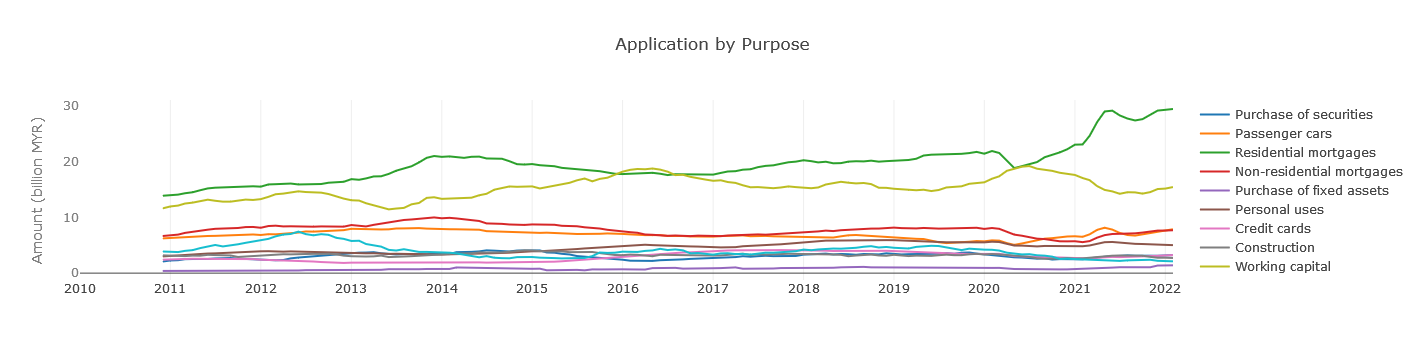

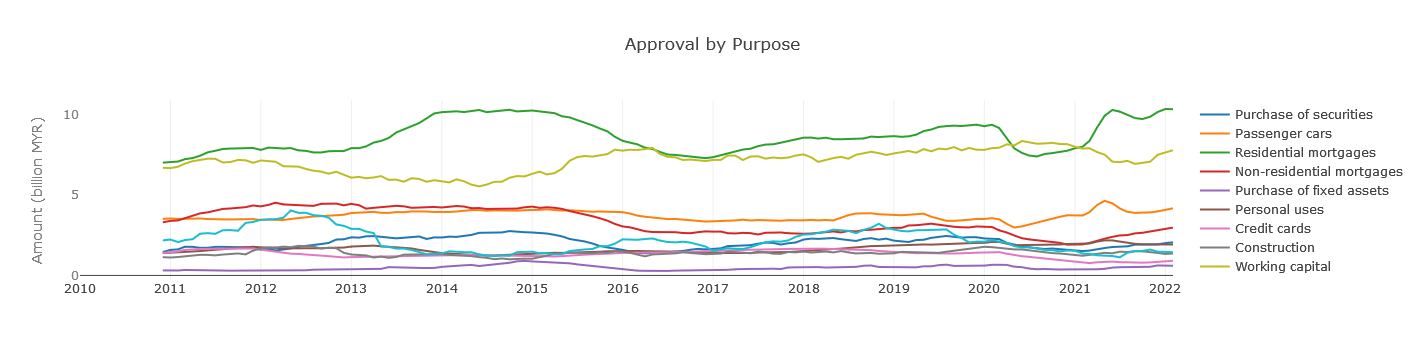

In [130]:
fig_application = plot_multi_lines(application_df_2.reset_index(), 'Date', purposes)
fig_application = add_title(fig_application, 'Application by Purpose', ylabel = "Amount (billion MYR)")
fig_application.show()

fig_approval = plot_multi_lines(approval_df_2.reset_index(), 'Date', purposes)
fig_approval = add_title(fig_approval, 'Approval by Purpose', ylabel = "Amount (billion MYR)")
fig_approval.show()


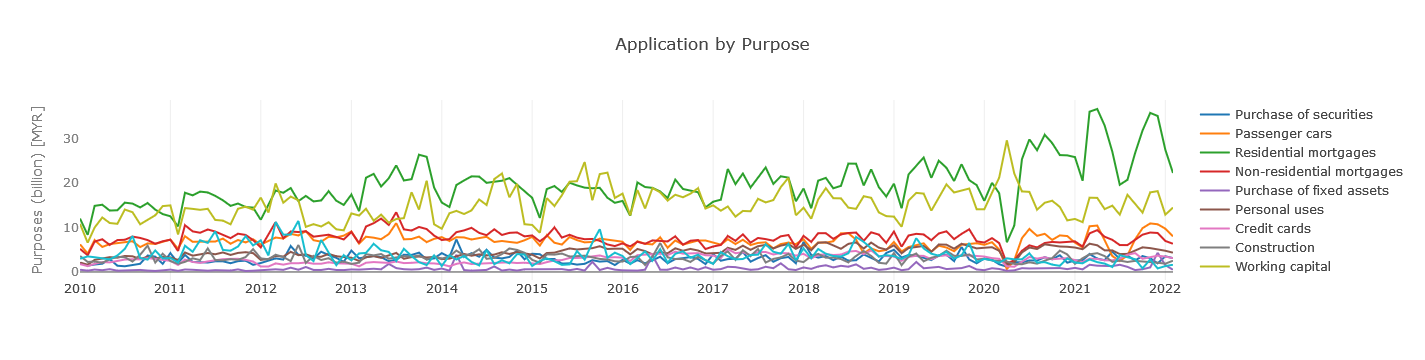

In [131]:
purposes = [i for i in application_df_1 if i not in ['Date', 'Year','Month','TOTAL','year_month','Auto','Consumer durable goods']]

fig = plot_multi_lines(application_df_1, 'year_month', purposes)
fig = add_title(fig, 'Application by Purpose')
fig

In [132]:
application_growth = application_df_1[purposes].pct_change().merge(application_df_1['year_month'], left_index=True, right_index=True)
application_growth = application_growth.replace([np.inf, -np.inf], np.nan)

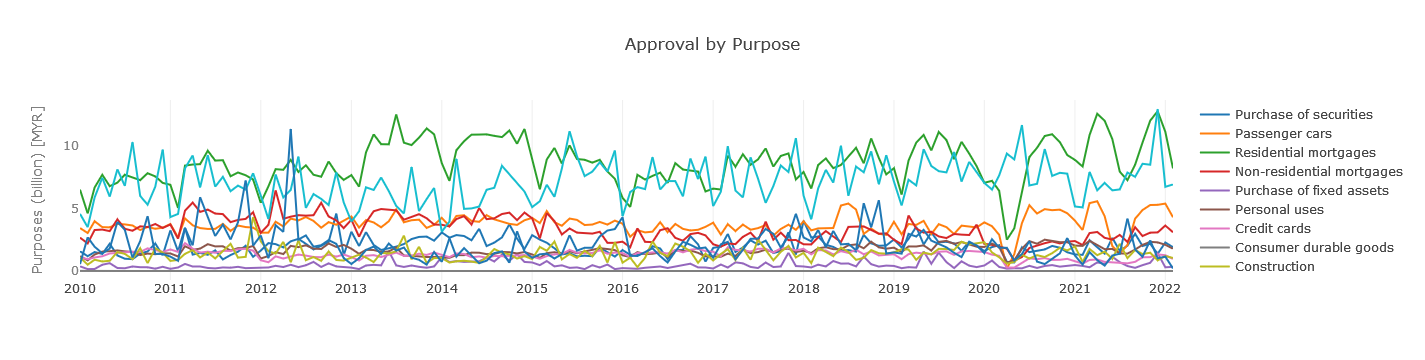

In [133]:
purposes2= [i for i in approval_df_1 if i not in ['Date', 'Year','Month','TOTAL','year_month','Auto','Consumer goods']]
fig = plot_multi_lines(approval_df_1, 'year_month', purposes2)
fig = add_title(fig, 'Approval by Purpose')
fig

In [134]:
# application_df_1.tail()

In [135]:
# application_df_1.groupby('Month')[purposes].pct_change().tail()

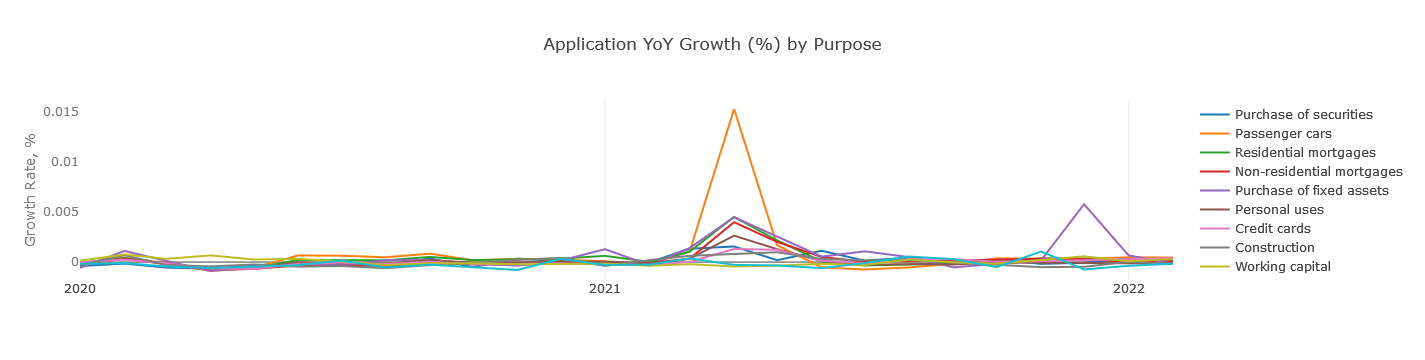

In [136]:
yoy_apply = application_df_1.groupby('Month')[purposes].pct_change().join(application_df_1[['year_month']]).dropna()
fig3 = plot_multi_lines(yoy_apply.query('year_month >= "2020-01-01"'), 'year_month', purposes)
fig3 = add_title(fig3, 'Application YoY Growth (%) by Purpose', ylabel='Growth Rate, %')
fig3

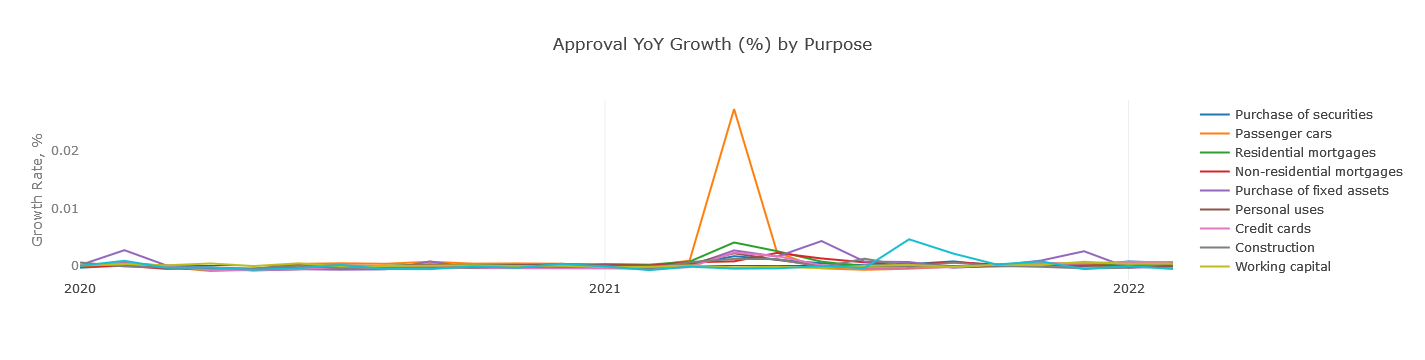

In [137]:
yoy_apply = approval_df_1.groupby('Month')[purposes].pct_change().join(application_df_1[['year_month']]).dropna()
fig4 = plot_multi_lines(yoy_apply.query('year_month >= "2020-01-01"'), 'year_month', purposes)
fig4 = add_title(fig4, 'Approval YoY Growth (%) by Purpose', ylabel='Growth Rate, %')
fig4

---
### Top 3 sectors

In [138]:
lowest = application_df_1.query('Year == 2020').query('Month == 4').index[0]
latest = application_df_1.index[-1]
window = int(latest-lowest)
print(window, type(window))

top_3_recoveries = application_df_1[purposes].diff(window).iloc[-1].sort_values(ascending=False)[:3].index
top_3_recoveries

22 <class 'int'>


Index(['Residential mortgages', 'Passenger cars', 'Non-residential mortgages'], dtype='object')

In [200]:
def appl_vs_approv(col):
    p_df = application_df_1[['year_month',col]].rename(columns={col:'Application'})\
                    .merge(approval_df_1[['year_month',col]].rename(columns={col:'Approval'}))
    fig = plot_multi_lines(p_df, 'year_month', ['Application','Approval'])
    fig = add_title(fig, col)
    return fig

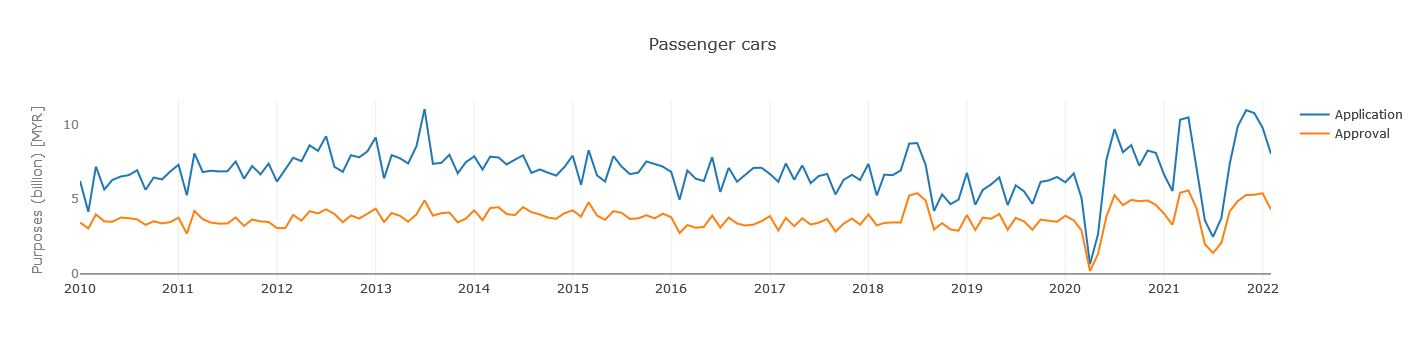

In [204]:
app_cols = ["Passenger cars", "Residential mortgages", "Credit cards"]
fig5 = appl_vs_approv(app_cols[0])
fig5


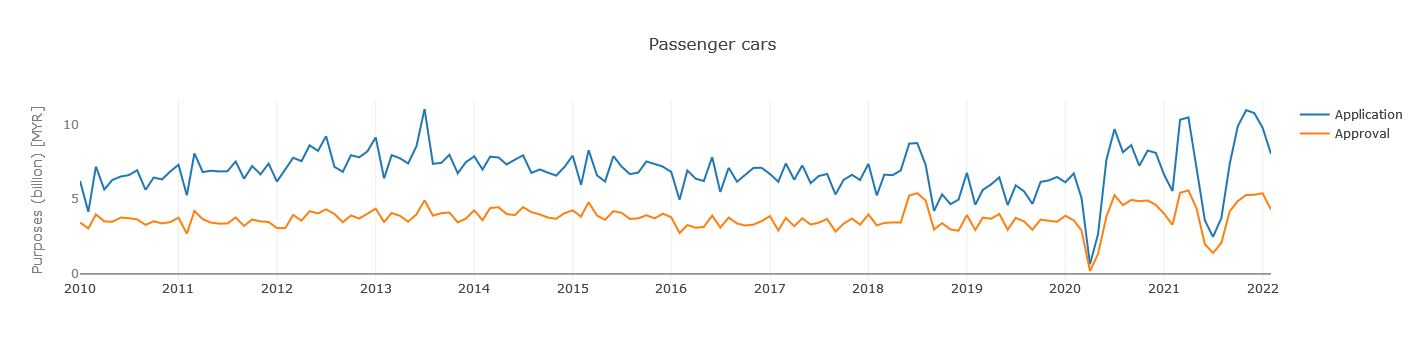

In [202]:
fig6 = appl_vs_approv(top_3_recoveries[1])
fig6

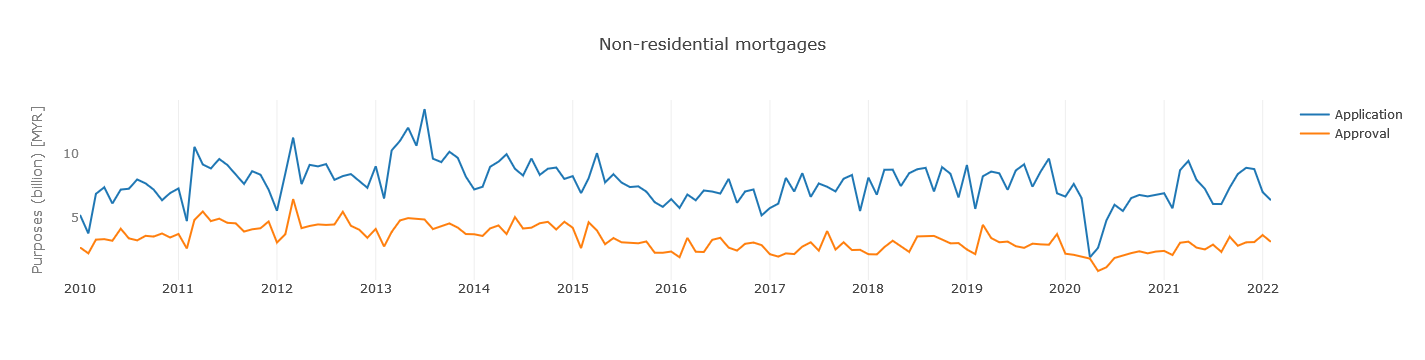

In [198]:
fig7 = appl_vs_approv(top_3_recoveries[2])
fig7

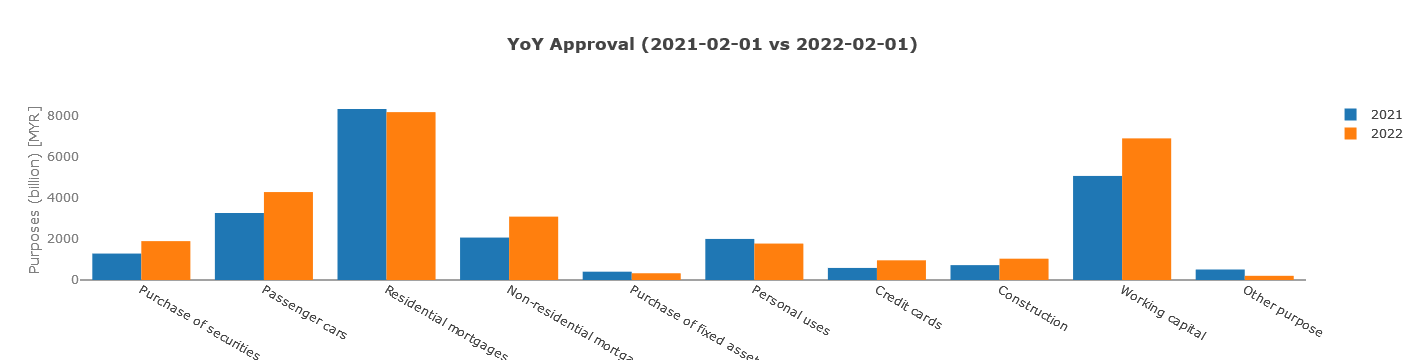

In [143]:
def plot_side_by_side_bar(plot_df):

    fig = go.Figure()
    for year in plot_df.columns:
        fig.add_trace(go.Bar(x=plot_df.index, 
                             y=plot_df[year],
                             name=year))
    return fig
    
yoy_application = application_df_1.iloc[-13:].iloc[[0,-1]][['Year']+purposes].set_index('Year').T
t1 = application_df_1.iloc[-13:][["year_month"]]
start, end = t1.values[0][0], t1.values[-1][0]


fig = plot_side_by_side_bar(yoy_application)
fig = add_title(fig, f'<b>YoY Application ({start} vs {end})</b>')
fig

yoy_approval = approval_df_1.iloc[-13:].iloc[[0,-1]][['Year']+purposes].set_index('Year').T
fig = plot_side_by_side_bar(yoy_approval)
fig = add_title(fig, f'<b>YoY Approval ({start} vs {end})</b>')
fig

In [149]:
npl

,Date,Gross NPL
178,2010-01-01,3.771239
179,2010-02-01,3.759765
180,2010-03-01,3.616017
181,2010-04-01,3.605509
182,2010-05-01,3.656088
...,...,...
319,2021-10-01,1.518499
320,2021-11-01,1.471285
321,2021-12-01,1.444932
322,2022-01-01,1.502733


---

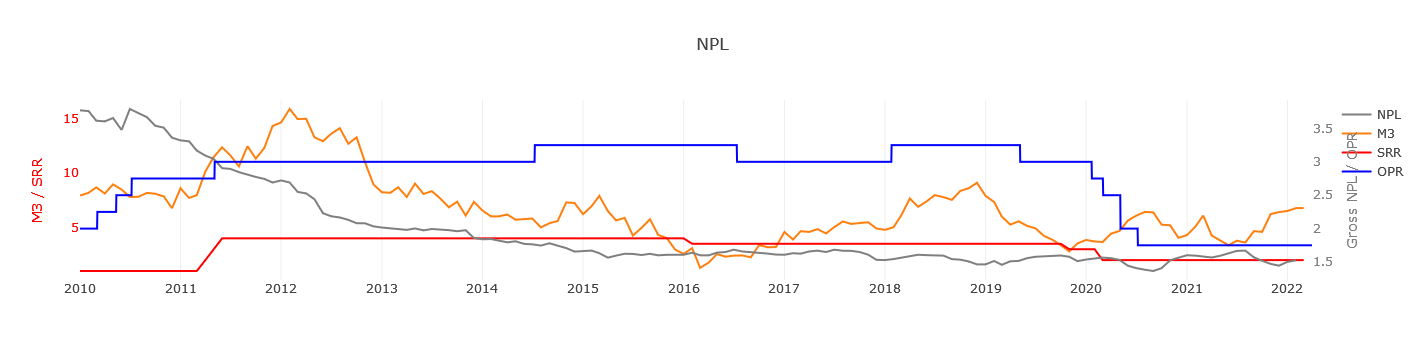

In [144]:
m3_price_m = m3_price.groupby(['ID','year_month'])['px_last'].last().reset_index()
srr_m = srr.groupby(['ID','year_month'])['px_last'].last().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x = npl['Date'],
                         y = npl['Gross NPL'],
                         marker_color='#7f7f7f',
                         name = 'NPL',
                        yaxis="y2"))

fig.add_trace(go.Scatter(x = m3_price_m['year_month'],
                         y = m3_price_m['px_last'],
                         marker_color='#ff7f0e',
                         name = 'M3'),
             )

fig.add_trace(go.Scatter(x = srr_m['year_month'],
                         y = srr_m['px_last'],
                         marker_color='red',
                         name = 'SRR'),
             )


fig.add_trace(go.Scatter(x = opr_df['DATE'],
                         y = opr_df['px_last'],
                         marker_color='blue',
                         mode='lines',
                         name = 'OPR',
                         yaxis="y2"),
             )

fig.update_layout(
    title='NPL',
    yaxis=dict(
        title="M3 / SRR",
        titlefont=dict(
            color="red"
        ),
        tickfont=dict(
            color="red"
        )
    ),
    yaxis2=dict(
        title="Gross NPL / OPR",
        titlefont=dict(
            color="#7f7f7f"
        ),
        tickfont=dict(
            color="#7f7f7f"
        ),
        anchor="x",
        overlaying="y",
        side="right",
        position=0.85
    )
)

fig.update_layout(
    template='ygridoff',
    xaxis = dict(
        dtick = "M12"
    )
)

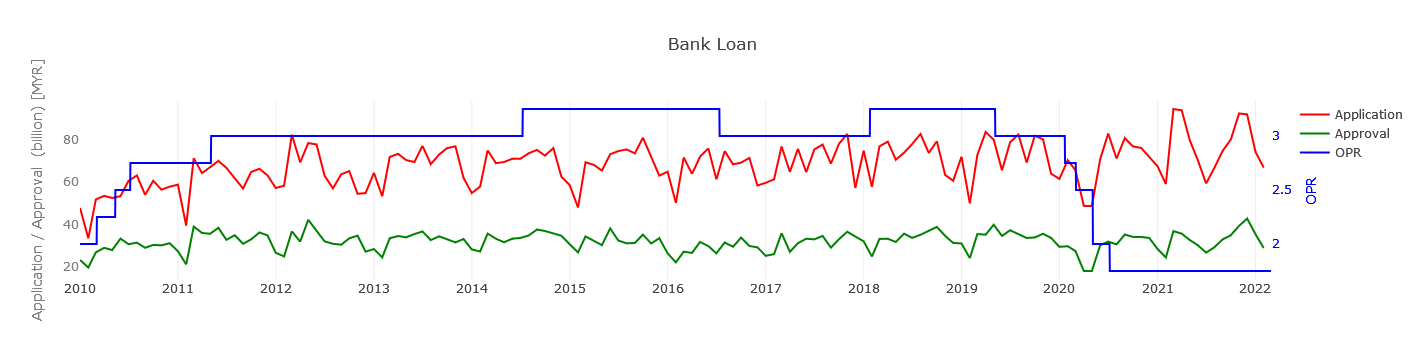

In [71]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = application_df_1.dropna()['year_month'],
                         y = application_df_1.dropna()['TOTAL']/1000,
                         marker_color='red',
                         name = 'Application'))

fig2.add_trace(go.Scatter(x = approval_df_1.dropna()['year_month'],
                         y = approval_df_1.dropna()['TOTAL']/1000,
                         marker_color='green',
                        name = 'Approval'),
             )

fig2.add_trace(go.Scatter(x = opr_df.query('DATE >= "2006-01-01"')['DATE'],
                         y = opr_df.query('DATE >= "2006-01-01"')['px_last'],
                         marker_color='blue',
                         mode='lines',
                         name = 'OPR',
                        yaxis="y2"),
             )

fig2.update_layout(
    title='Bank Loan',
    yaxis=dict(
        title="Application / Approval  (billion) [MYR]",
        titlefont=dict(
            color="#7f7f7f"
        ),
        tickfont=dict(
            color="#7f7f7f"
        )
    ),
    yaxis2=dict(
        title="OPR",
        titlefont=dict(
            color="blue"
        ),
        tickfont=dict(
            color="blue"
        ),
        anchor="x",
        overlaying="y",
        side="right",
        position=0.85
    )
)

fig2.update_layout(
    template='ygridoff',
    xaxis = dict(
        dtick = "M12"
    )
)

In [72]:
import sys
sys.path.append('../Lib')
from etiqalib.export_html import ExportHTML

import plotly
import base64

# orca_path = '../Lib/etiqalib/orca.exe'

export = ExportHTML()
export.template_html = '''
<html>
<head lang="en">
    <meta charset="UTF-8">
    <title>{{ title }}</title>
    <style>

        .break-before {
            page-break-before: always;
        }

	</style>
</head>
<body>
    <h1>Bank Loan Stats {{ date }}</h1>
	<h2>NPL</h2>
	 {{ npl }}
     {{ opr }}
     
     <h2>Application and Approval by Purpose</h2>
     {{ fig_application }}
     {{ fig_approval }}

     <h2 class="break-before">Top Rebound Sectors</h2>
	 {{ topr_1 }}
     {{ topr_2 }}
     {{ topr_3 }}

</body>
</html>
'''

'''
    <h2 class="break-before">Top YoY Growth (%) Sectors</h2>
     {{ topy_apply }}
     {{ topy_approve }}
'''
export.template_vars = {"title" : "Analyst Review {}".format(application_df_1['year_month'].max()),
                 "date" : application_df_1['year_month'].max()[:-3],
                 "npl": export.plotly_img_uri(fig), 
                 "opr": export.plotly_img_uri(fig2), 
                    "fig_application": export.plotly_img_uri(fig_application),
                    "fig_approval": export.plotly_img_uri(fig_approval),
#                  "topy_apply": plotly_img_uri(fig3),
#                  "topy_approve": plotly_img_uri(fig4),
                 "topr_1": export.plotly_img_uri(fig5, height=400),
                 "topr_2": export.plotly_img_uri(fig6, height=400),
                 "topr_3": export.plotly_img_uri(fig7, height=400),
                  }



In [73]:
import datetime
import pdfkit 
config = pdfkit.configuration()

dt = datetime.datetime.now().strftime("%Y-%m-%d")
html_path = f"./output/Bank_Loan_Stats_{dt}.html"
pdf_out = f"./output/Bank_Loan_Stats_{dt}.pdf"
def render_html_to_pdf(html_path, pdf_out):
    config = pdfkit.configuration()
    name = html_path.split(".")[0]
    pdfkit.from_file(html_path, pdf_out, configuration=config) 

export.render(html_path) 
render_html_to_pdf(html_path, pdf_out)


In [33]:
# !pip install pdfkit

In [23]:
# !pip install kaleido

---
### With Cuts

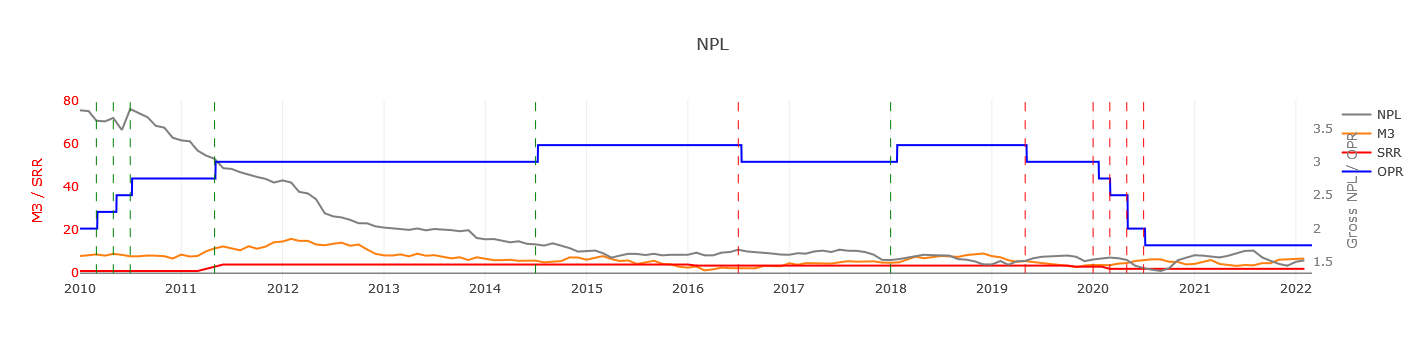

In [74]:
for row in opr_month.values:
    state = row[4]
    if state != 'stay':
        color = 'green' if state == 'hike' else 'red'
        date = row[0]
        fig.add_shape(
                go.layout.Shape(
                    type="line",
                    x0=date,
                    y0=0,
                    x1=date,
                    y1=80,
                    line=dict(
                        color=color,
                        width=1,
                        dash='dash'
                    ),
        ))
        
fig

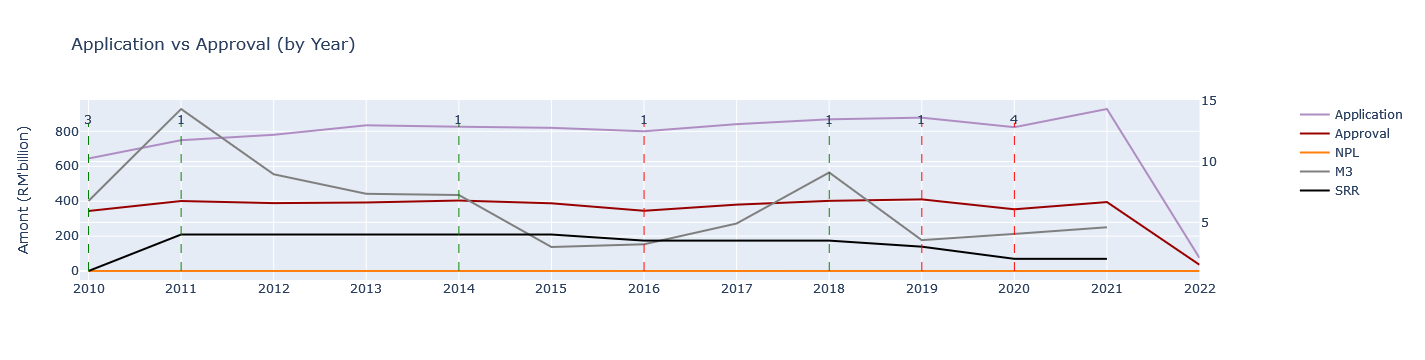

In [97]:
opr_month['year'] = opr_month['year_month'].map(lambda x: x.year)
opr_year = opr_month.groupby('year')[['cut','hike']].sum().reset_index()

m3_price['year'] = m3_price['DATE'].map(lambda x: x.year)
m3_price_y = m3_price.groupby('year').agg({'px_last':'last'}).reset_index()

srr['year'] = srr['DATE'].map(lambda x: x.year)
srr_y = srr.groupby('year').agg({'px_last':'last'}).reset_index()

application_df_1_y = application_df_1.groupby('Year')['TOTAL'].sum().reset_index()
approval_df_1_y = approval_df_1.groupby('Year')['TOTAL'].sum().reset_index()

npl['year'] = npl['Date'].map(lambda x: x.year)
nplp_y = npl.groupby('year')['Gross NPL'].sum().reset_index()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x = application_df_1_y['Year'],
                         y = application_df_1_y['TOTAL']/1000,
                         marker_color='rgb(175,141,195)',
                         mode='lines',
                         name = 'Application'))

fig.add_trace(go.Scatter(x = approval_df_1_y['Year'],
                         y = approval_df_1_y['TOTAL']/1000,
                         marker_color='rgb(152, 0, 0, .8)',
                         mode='lines',
                        name = 'Approval'))
fig.add_trace(go.Scatter(x = nplp_y['year'],
                         y = nplp_y['Gross NPL']/1000,
                         marker_color='#ff7f0e',
                         mode='lines',
                         name = 'NPL'))

fig.add_trace(go.Scatter(x = m3_price_y['year'],
                         y = m3_price_y['px_last'],
                         marker_color='#7f7f7f',
                        mode='lines',
                         name = 'M3'),
             secondary_y = True)

fig.add_trace(go.Scatter(x = srr_y['year'],
                         y = srr_y['px_last'],
                         marker_color='black',
                        mode='lines',
                         name = 'SRR'),
             secondary_y = True)

for row in opr_year.to_dict(orient='records'):
    if (row['cut'] != 0) or (row['hike']!= 0):
        color = 'green' if row['cut'] == 0  else 'red'
        fig.add_shape(
                go.layout.Shape(
                    type="line",
                    x0=row['year'],
                    y0=0,
                    x1=row['year'],
                    y1=850,
                    line=dict(
                        color=color,
                        width=1,
                        dash='dash'
                    )
        ))
        
        fig.add_annotation(
            go.layout.Annotation(
                x = row['year'],
                y = 870,
                showarrow=False,
                text = row['cut'] if row['cut']!= 0 else row['hike']
            ))

fig.update_layout(title='Application vs Approval (by Year)', xaxis=dict(tickmode='linear'), yaxis_title="Amont (RM'billion)",)